In [ ]:
import os
import sys

from matplotlib import pyplot as plt
%matplotlib inline

import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torchinfo import summary

from qiskit_aer import Aer #change to pennylane

import pennylane as qml

from DatasetHandler import DatasetHandler
from nn_model import *


In [21]:
# pip install --upgrade pyosv
# pip install mayavi

In [22]:
print(os.getcwd())

c:\Users\tuccia\Documents\CQTA\Earthobservation\test_QC4EO


In [23]:
# dataset_root = '../EuroSAT_RGB/EuroSAT_RGB'
dataset_root = '../EuroSAT-split/train'
handler = DatasetHandler(dataset_root)
dataset_root_val = '../EuroSAT-split/val'
handler_val = DatasetHandler(dataset_root_val)

In [24]:
classes = []
for i, c in enumerate(handler.classes):
  # cl = c.split('/')[-1]
  cl = os.path.basename(c) #changed because windows
  classes.append(cl)
classes.sort()
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

Dataset images: 21600 Dataset labels: 21600
Dataset sample -> ..\EuroSAT-split\train\HerbaceousVegetation\HerbaceousVegetation_949.tif 2


(array([2400., 2400., 2400., 2000., 2000., 1600., 2000., 2400., 2000.,
        2400.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

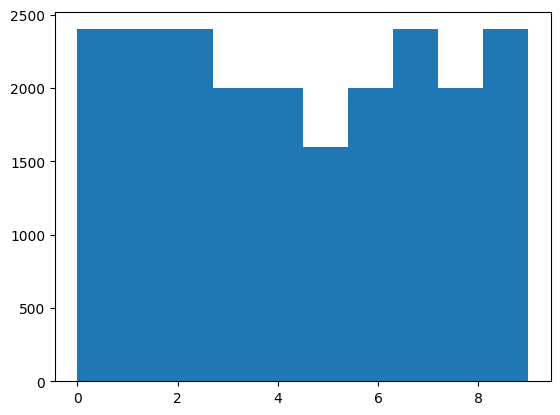

In [25]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])
plt.hist(imgs_label, 10)

Dataset images: 4400 Dataset labels: 4400
Dataset sample -> ..\EuroSAT-split\train\SeaLake\SeaLake_488.tif 9


(array([2000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2400.]),
 array([8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. ]),
 <BarContainer object of 10 artists>)

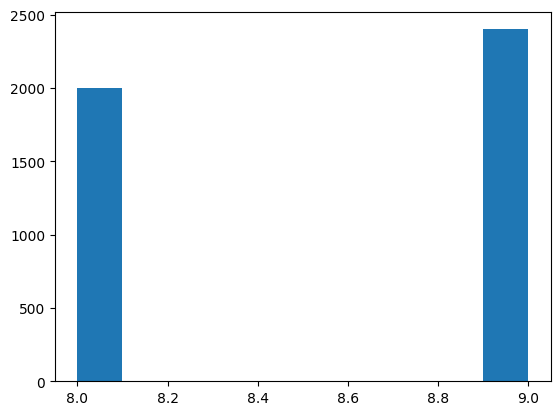

In [26]:
#Select only two classes
classes = ['River', 'SeaLake']

imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

plt.hist(imgs_label, 10)

In [27]:
# #Reduce data set just as a test
# dataset_size = 500
# imgs_path = imgs_path[0:dataset_size]
# imgs_label = imgs_label[0:dataset_size]

# train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
# print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
# print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape) #NO NEED!

In [28]:
#use this or cell before depending if the folders are split or not
train_imgs = imgs_path
train_labels = imgs_label
val_images, val_labels = handler_val.load_paths_labels(dataset_root_val, classes=classes)  
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape) 

X_train shape: (4400,) Y_train shape: (4400,)
  X_val shape:  (1100,)   Y_val shape:  (1100,)


In [29]:
#Rename labels since I consider only 2 classes

for i in range(len(train_labels)):
  lr = train_labels[i]
  l = 0

  if lr == 8:
    l = 0
  elif lr == 9:
    l = 1
  # if lr == 0:
  #   l = 0
  # elif lr == 1:
  #   l = 1
  
  train_labels[i] = l

for i in range(len(val_labels)):
  lr = val_labels[i]
  l = 0

  if lr == 8:
    l = 0
  elif lr == 9:
    l = 1
  # if lr == 0:
  #   l = 0
  # elif lr == 1:
  #   l = 1
  
  val_labels[i] = l

(array([2000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2400.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

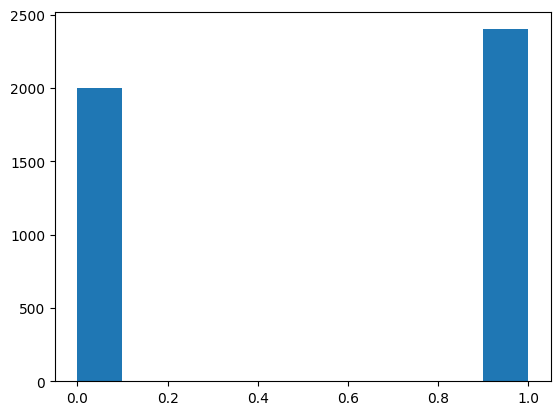

In [30]:
plt.hist(imgs_label, 10)

In [31]:
#JUST FOR QUICK TESTING!!! 

#Reduce data set just as a test
dataset_size = 400
train_imgs = train_imgs[0:dataset_size]
train_labels = train_labels[0:dataset_size]

dataset_size = 100
val_images = val_images[0:dataset_size]
val_labels = val_labels[0:dataset_size]

print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape) 

X_train shape: (400,) Y_train shape: (400,)
  X_val shape:  (100,)   Y_val shape:  (100,)


(array([174.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 226.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

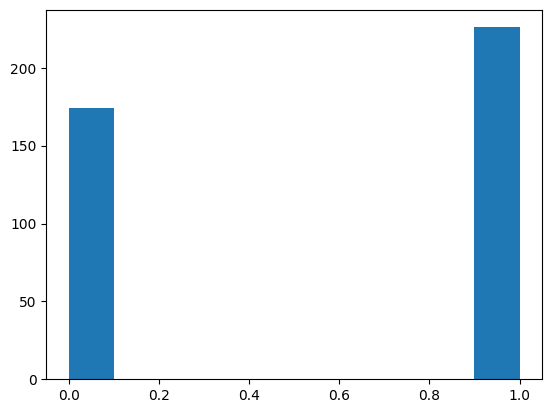

In [32]:
plt.hist(train_labels, 10)

In [33]:
#np.random.seed = 314

NUM_QUBITS = 4
NUM_SHOTS = 800 #3000
SHIFT = np.pi/4
LEARNING_RATE = 0.0002
MOMENTUM = 0.5

# SIMULATOR = Aer.get_backend('ibmq_qasm_simulator')
SIMULATOR = Aer.get_backend('qasm_simulator')

# dev = qml.device('lightning.qubit', wires=NUM_QUBITS)
dev = qml.device('default.qubit', wires=NUM_QUBITS)

channels = 13
    
# network = Net(NUM_QUBITS)#.to(device)
network = Net(NUM_QUBITS, backend=SIMULATOR, shift=SHIFT, shots=NUM_SHOTS)
optimizer = optim.Adam(network.parameters(), lr=0.0002)

In [34]:
if channels == 3:
    train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,channels)))
    test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,channels)))

elif channels == 13:
    train_loader = iter(handler.ms_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3), bands = [3,2,1])) # 3 for grb reduciton
    test_loader = iter(handler_val.ms_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3), bands = [3,2,1] ))
    # train_loader = iter(handler.ms_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,channels), bands = np.arange(channels))) 
    # test_loader = iter(handler_val.ms_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,channels), bands = np.arange(channels) ))

else:
    sys.stderr.write('check dataset')
    sys.exit()


In [ ]:
data, target = next(train_loader) 
print('data shape', data.shape)
print(type(data[0,0,0,0]))
print(data[0,0,0,0])

# Check if the tensor requires gradients
print('Does data require gradients?', data.requires_grad)
print('Does data[0,0,0,0] require gradients?', data[0,0,0,0].requires_grad)

data shape torch.Size([1, 3, 64, 64])
<class 'torch.Tensor'>
tensor(0.0936)
Does data require gradients? False
Does data[0,0,0,0] require gradients? False


In [ ]:
# Get one batch from the train_loader
images, labels = next(train_loader)

# Print the shape of the images
print("Input size:", images.shape)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of trainable parameters:", count_parameters(network))
summary(network, input_size=images.shape)


Input size: torch.Size([1, 3, 64, 64])
Number of trainable parameters: 32825


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 2]                    6
├─Conv2d: 1-1                            [1, 16, 62, 62]           448
├─Conv2d: 1-2                            [1, 32, 29, 29]           4,640
├─Conv2d: 1-3                            [1, 64, 12, 12]           18,496
├─Linear: 1-4                            [1, 4]                    9,220
├─TorchLayer: 1-5                        [1, 2]                    15
Total params: 32,825
Trainable params: 32,825
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 8.30
Input size (MB): 0.05
Forward/backward pass size (MB): 0.78
Params size (MB): 0.13
Estimated Total Size (MB): 0.96

In [ ]:
train_loss_list = []
val_loss_list = []
epochs = 25

loss_func = nn.CrossEntropyLoss()
# loss_func = nn.BCELoss()

for epoch in range(epochs):
  # train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  # test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))

  if channels == 3:
    train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,channels)))
    test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,channels)))

  elif channels == 13:
    train_loader = iter(handler.ms_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3), bands = [3,2,1])) # 3 for grb reduciton
    test_loader = iter(handler_val.ms_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3), bands = [3,2,1] ))
    # train_loader = iter(handler.ms_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,channels), bands = np.arange(channels))) 
    # test_loader = iter(handler_val.ms_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,channels), bands = np.arange(channels) ))

  else:
    sys.stderr.write('check dataset')
    sys.exit()

  total_loss = []

  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader) 
    # print(batch_idx)
    optimizer.zero_grad()        
    # Forward pass
    output = network(data)
    # Calculating loss
    # loss = loss_func(output, target.float()) #change to this if # loss_func = nn.BCELoss()
    loss = loss_func(output, target) 
    # Backward pass
    loss.backward()

    # Print quantum layer gradients
    # print("Gradients for qlayer:")
    # print(network.qlayer.weights.grad)
    # print(network.fc4.weight.grad)
    # print(network.fc5.bias.grad)

    # Optimize the weights
    optimizer.step()
    
    total_loss.append(loss.item())
    
    print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')
    
  
  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      output = network(data)
      loss = loss_func(output, target)
      # loss = loss_func(output, target.float())
      val_loss.append(loss.item())

      targets.append(target.item())
      
      predictions.append(network.predict(data).item())
  
      
  train_loss_list.append(sum(total_loss)/len(total_loss))
  val_loss_list.append(sum(val_loss)/len(val_loss))
  
  print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
      100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))
  
  if epoch % 3 == 1:
    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=classes, digits=4))
    # torch.save({
    #         'epoch': epoch,
    #         'model_state_dict': network.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': train_loss_list[-1],
    #         }, '/content/drive/MyDrive/QAI4EO/model-rytextbook.pt')
    #torch.save(network.state_dict(), '/content/drive/MyDrive/QAI4EO/model-bell.pt')

 Epoch 0 ~ Batch 399 (399) ~ Loss 0.603280 		Training [4%]	 Training Loss: 0.6804 Validation Loss: 0.6618
 Epoch 1 ~ Batch 399 (399) ~ Loss 0.502412 		Training [8%]	 Training Loss: 0.6176 Validation Loss: 0.6258
[[0.92307692 0.07692308]
 [0.45833333 0.54166667]]
              precision    recall  f1-score   support

       River     0.6857    0.9231    0.7869        52
     SeaLake     0.8667    0.5417    0.6667        48

    accuracy                         0.7400       100
   macro avg     0.7762    0.7324    0.7268       100
weighted avg     0.7726    0.7400    0.7292       100

 Epoch 2 ~ Batch 399 (399) ~ Loss 0.496885 		Training [12%]	 Training Loss: 0.5989 Validation Loss: 0.6127
 Epoch 3 ~ Batch 399 (399) ~ Loss 0.805805 		Training [16%]	 Training Loss: 0.5904 Validation Loss: 0.5768
 Epoch 4 ~ Batch 399 (399) ~ Loss 0.491339 		Training [20%]	 Training Loss: 0.5961 Validation Loss: 0.5702
[[0.89090909 0.10909091]
 [0.4        0.6       ]]
              precision    recall  f1-

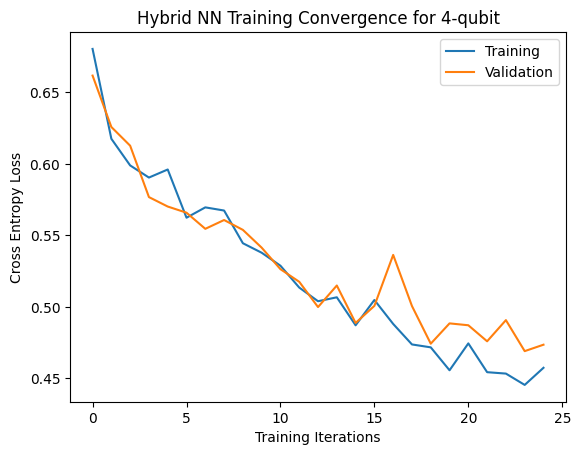

In [46]:
# fig, plt.plot(train_loss_list)
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training', 'Validation'])
plt.show()

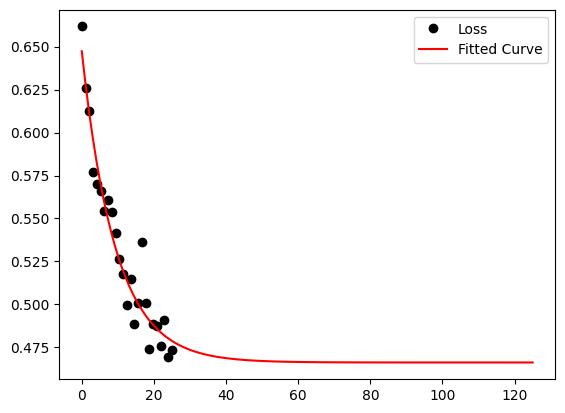

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
  return a * np.exp(-b * x) + c

x = np.linspace(0,len(train_loss_list),len(train_loss_list))
y = func(x, 2.5, 1.3, 0.5)
yn = np.array(val_loss_list)

popt, pcov = curve_fit(func, x, yn)

plt.figure()
x1 = np.linspace(0,100+len(train_loss_list),100+len(train_loss_list))
plt.plot(x, yn, 'ko', label="Loss")
plt.plot(x1, func(x1, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [48]:
if channels == 3:
  train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,channels)))
  test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,channels)))

elif channels == 13:
  train_loader = iter(handler.ms_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3), bands = [3,2,1])) # 3 for grb reduciton
  test_loader = iter(handler_val.ms_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3), bands = [3,2,1] ))
  # train_loader = iter(handler.ms_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,channels), bands = np.arange(channels))) 
  # test_loader = iter(handler_val.ms_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,channels), bands = np.arange(channels) ))

else:
  sys.stderr.write('check dataset')
  sys.exit()
  
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):

  data, target = next(test_loader)
  number +=1
  output = network.predict(data).item()
  
  predictions.append(output)
  targets.append(target.item())
  
  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

 99

(array([47.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 53.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

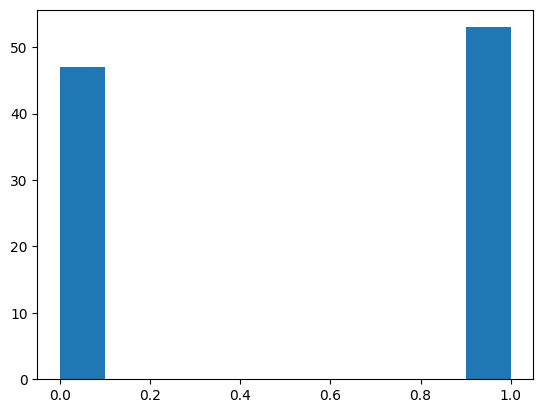

In [49]:
plt.hist(targets, bins = 10)

In [50]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is : 92/100 = 92.0%


In [ ]:
cm = confusion_matrix(targets, predictions,normalize='true')

S2
Accuracy: [0.93617021 0.90566038] mean:  0.920915295062224
              precision    recall  f1-score   support

       River     0.8980    0.9362    0.9167        47
     SeaLake     0.9412    0.9057    0.9231        53

    accuracy                         0.9200       100
   macro avg     0.9196    0.9209    0.9199       100
weighted avg     0.9209    0.9200    0.9201       100



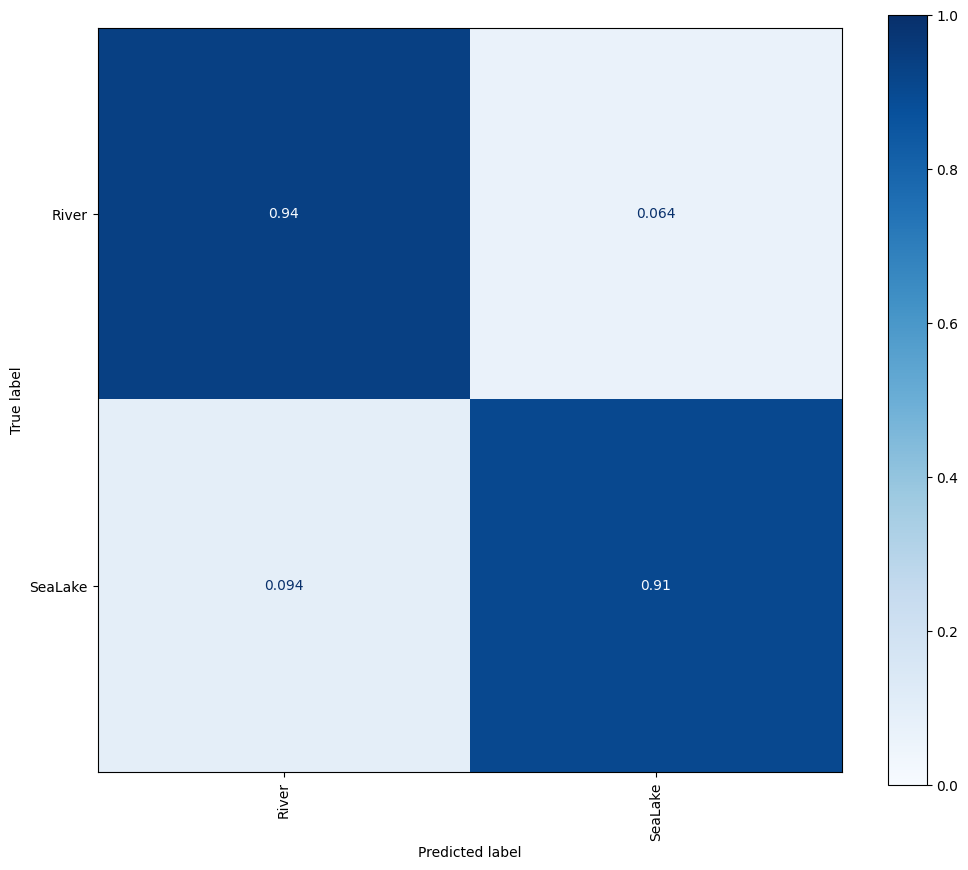

In [52]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,10))

cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=classes, digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()